<a href="https://colab.research.google.com/github/sawesky/deep-stegano/blob/masterpsnrlinnaeus5/Diplomski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar

--2023-05-29 17:15:50--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘Linnaeus 5 128X128.rar’

Linnaeus 5 128X128. 100%[===================>] 132.54M  43.2MB/s    in 3.2s    

2023-05-29 17:15:53 (41.2 MB/s) - ‘Linnaeus 5 128X128.rar’ saved [138983573/138983573]



In [ ]:
!unrar x "/content/Linnaeus 5 128X128.rar"

In [3]:
!pip install Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.utils as image #mora da se doda da prekrsi preprocessing image 
import keras.backend as K

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [11]:
### Constants ###
DATA_DIR = "./Linnaeus 5 128X128"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (128, 128)

In [12]:
def load_dataset_small(num_images_per_class_train=400, num_images_test=50):

    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    for test in os.listdir(TEST_DIR):
        test_dir = os.path.join(TEST_DIR, test)
        test_imgs = os.listdir(test_dir)
        random.shuffle(test_imgs)
        for img_name_i in test_imgs[0:num_images_test]:
            img_i = image.load_img(os.path.join(test_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [13]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 256, 256, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 128, 128, 3)


In [14]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

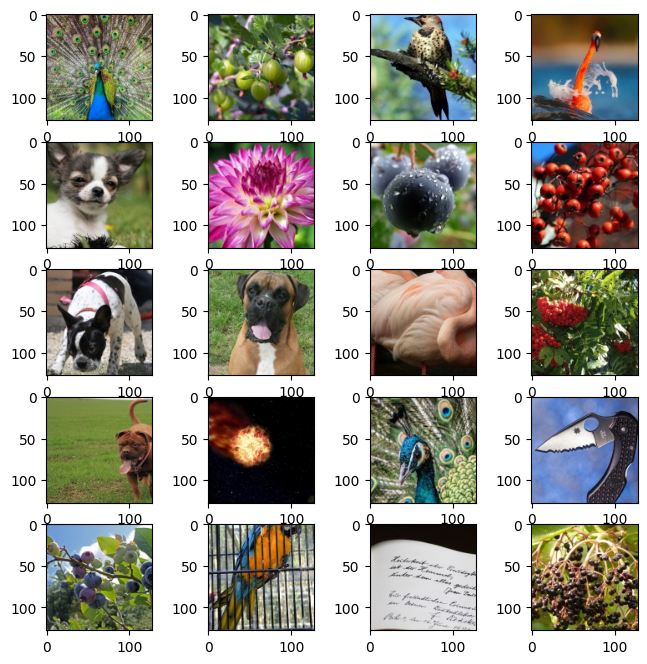

In [15]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [16]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 0.8
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    loss = beta * tf.reduce_sum(tf.square(s_true - s_pred)/(64*64))
    return loss

def psnr_loss(y_true, y_pred):
    n = tf.reduce_max(y_true)  # Max pixel value in y_true
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    psnr = 10 * tf.math.log(10.0) / tf.math.log(10.0) * tf.math.log(n**2 / mse)
    return 1 / psnr

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = beta * psnr_loss(s_true, s_pred)
    c_loss = psnr_loss(c_true, c_pred)
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x5)
    x = concatenate([x3, x4, x5])
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(reveal_input)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(reveal_input)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(reveal_input)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=psnr_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [17]:
def lr_schedule(epoch_idx):
    if epoch_idx < 100:
        return 0.001
    elif epoch_idx < 200:
        return 0.0003
    elif epoch_idx < 300:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 400
BATCH_SIZE = 32
lr = 0.001
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
K.set_value(autoencoder_model.optimizer.lr,lr)
K.set_value(reveal_model.optimizer.lr,lr)
m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        aeloss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3))
        ae_loss.append(aeloss)

        revloss = reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S)
        rev_loss.append(revloss)
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

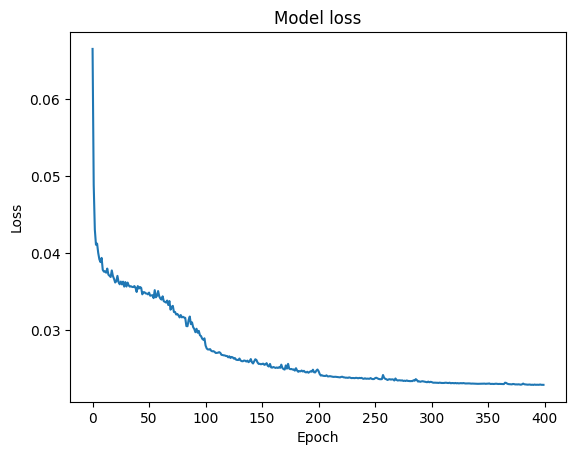

In [20]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 [==============================] - 3s 75ms/step


In [33]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    "MSE per pixel"
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    "histogrami gresaka"
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Raspodela greske u cover slici')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Raspodela greske u tajnoj slici')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [31]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 8.163466
C error per pixel [0, 255]: 3.0920541


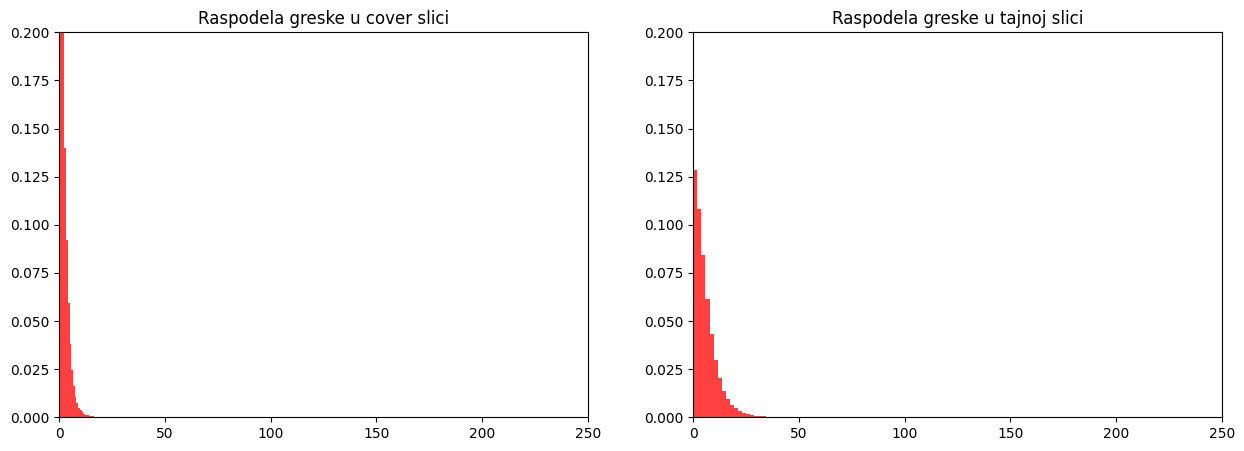

In [34]:
pixel_histogram(diff_S, diff_C)

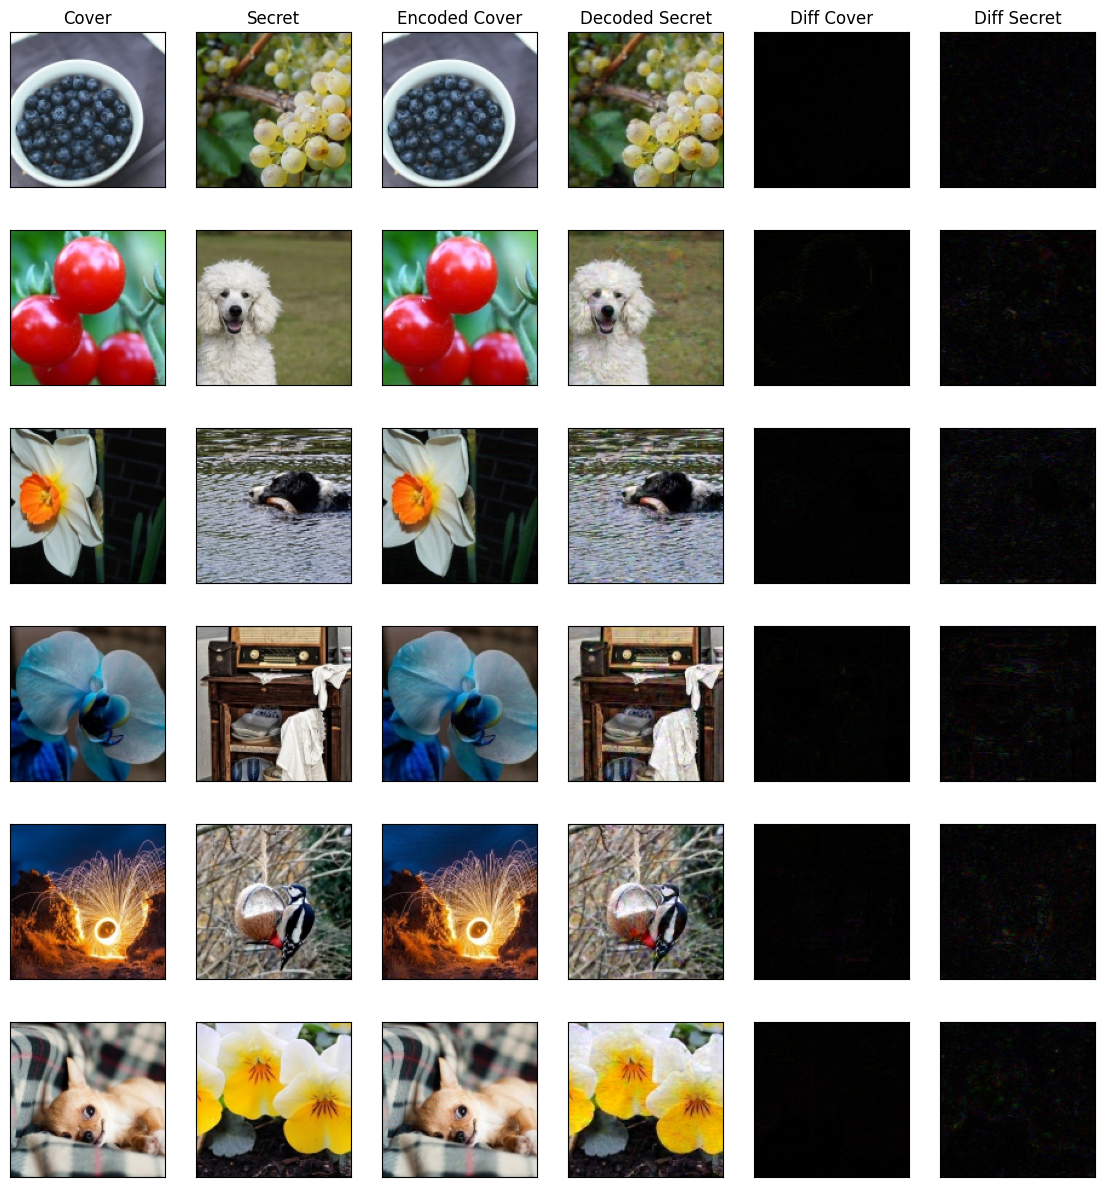

In [38]:
# Configs for results display

# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def show_image(img, n_rows, n_col, idx, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, first_row=i==0, title='Diff Secret')

plt.show()